In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('WaterUpdated.csv').drop('id', axis = 1)
df.target.replace({'functional': 0, 'non functional': 1, 'functional needs repair': 1}, inplace = True)
df.head(2)

,amount_tsh,gps_height,installer,basin,region,lga,ward,population,public_meeting,permit,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,time_passed,target
0,6000.0,1390,Roman,Lake Nyasa,Iringa,Ludewa,Mundindi,109.0,1,0,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,12,0
1,0.0,1399,GRUMETI,Lake Victoria,Mara,Serengeti,Natta,280.0,0,1,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,3,0


## Ensemble 

1. Start with softmax activation that predicts the probability of each class 
    - Feature Columns 
        - `amount_tsh`
        - `gps_height`
        - `basin` (one-hot) 
        - `population`
        - `permit`
        - `time_passed`
        - `public_meeting`
        - `payment` (one-hot) 
        - `water_quality` (one-hot)
        - `quantity` (one-hot)
        - `source` (one-hot)
        - `waterpoint_type` (one-hot)
    - Target = `target`

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
new_df = df
new_df = df.join(pd.get_dummies(df.basin, prefix = 'basin'))
new_df = new_df.join(pd.get_dummies(df.extraction_type, prefix = 'extract'))
new_df = new_df.join(pd.get_dummies(df.payment, prefix = 'payment'))
new_df = new_df.join(pd.get_dummies(df.quantity, prefix = 'quantity'))
new_df = new_df.join(pd.get_dummies(df.water_quality, prefix = 'quality'))
new_df = new_df.join(pd.get_dummies(df.source, prefix = 'source'))
new_df = new_df.join(pd.get_dummies(df.waterpoint_type, prefix = 'waterpoint'))


unique_basin = [f'basin_{i}' for i in df.basin.unique()]
unique_extract = [f'extract_{i}' for i in df.extraction_type.unique()]
unique_waterpoint = [f'waterpoint_{i}' for i in df.waterpoint_type.unique()]
unique_source = [f'source_{i}' for i in df.source.unique()]
unique_quality = [f'quality_{i}' for i in df.water_quality.unique()]
unique_quantity = [f'quantity_{i}' for i in df.quantity.unique()]
unique_payment = [f'payment_{i}' for i in df.payment.unique()]


col = ['amount_tsh', 'gps_height', 'population', 'permit', 'time_passed', 'target']
col = col + unique_basin + unique_extract + unique_waterpoint + unique_source + unique_quality + unique_quantity + unique_payment
new_df = new_df[col]
func_df = new_df[new_df.target == 0]
repair_df = new_df[new_df.target ==1]

resamp_repair = resample(repair_df, n_samples = len(func_df), random_state = 10)

resampled_concat = pd.concat([func_df, resamp_repair])
X = resampled_concat
y = resampled_concat[['target']]

x_train, x_test, y_train, y_test = train_test_split(X,y, stratify = X.target, random_state = 10, train_size = .85)
print(y_train.target.value_counts(), y_test.target.value_counts())
x_train = x_train.drop('target', axis =1)
x_test = x_test.drop('target', axis =1)
y_train = y_train.target.values.ravel()
y_test = y_test.target.values.ravel()

1    27420
0    27420
Name: target, dtype: int64 1    4839
0    4839
Name: target, dtype: int64


In [4]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from tqdm import tqdm
import pickle


models = {'log': LogisticRegression(solver = 'liblinear', max_iter = 1000), 
          'knn': KNeighborsClassifier(n_neighbors = 3),
          'dt': DecisionTreeClassifier(), 'bayes': GaussianNB(), 'rf': RandomForestClassifier(),
            }
#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 5)
models['stacked'] = stack_model

#test each model and stacking
results = []
model_names = []
pbar = tqdm(models.items())
for model, m in pbar: 
    pbar.set_description(f'Evaluating {model.upper()}')
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 4, random_state = 10)
    scores = cross_val_score(m, x_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = -1, 
                             error_score = 'raise')
    results.append(scores)
    model_names.append(model)
    

Evaluating STACKED: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [09:41<00:00, 96.98s/it]


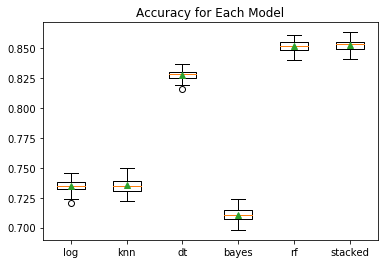

In [5]:
plt.boxplot(results, labels = model_names, showmeans = True)
plt.title('Accuracy for Each Model')
plt.show()

In [6]:
assert False

AssertionError: 

In [ ]:
train_pred = sgd.predict(x_train).reshape(-1,1)
test_pred = sgd.predict(x_test).reshape(-1,1)

print(classification_report(y_test, test_pred))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10],
    'max_features': [i for i in range(5,7)],
    'bootstrap': [True, False]
}
forest = RandomForestClassifier()
gs = GridSearchCV(forest, param_grid, verbose = 1, n_jobs =3)
gs.fit(x_train, y_train) 
f_predict = gs.predict(x_test)
print(classification_report(y_test, f_predict))